# Detecting Emotions From Audio With CNN

In this notebook I propose a very simple CNN architecture to classify audio clips by the emotion it contains.

The training pipeline works as follows:
- Audio clips are first converted into spectrograms, which are essentially 2D arrays, and downsampled to save training time
- The downsampled spectrograms are then fed to a two-layer vanilla convolutional neural network. The output is probability of labels computed by a softmax operation. 

The convolutional neural network is chosen because of its proficiency in learning both higher and lower level image features. When an audio sample is represented as a spectrogram, it is essentially an image and we can easily visualize features such as prosodies and intonations. These features are very useful in classifying emotions and the CNN architecture is very good at learning them. The CNN architecture is also robust against variations in audio quality, such as the pitch of the speaker.

The dataset here is the speech section of the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). The audio clips covers short speeches intoning 2 sentences with 8 different emotions by a female speaker and a male speaker. The dataset is found at https://zenodo.org/record/1188976#.W2R6RtVKick.

In [1]:
import os 
import glob
from pathlib import Path
import re 

audio_root_dir = Path(r'./processed_at_lv1')
audio_file_pattern = Path(r'**/*seg0.wav')

def get_emotion_label(filename):
    """
    Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier 
    (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

    Filename identifiers 

    Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    Vocal channel (01 = speech, 02 = song).
    Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    Repetition (01 = 1st repetition, 02 = 2nd repetition).
    Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
    
    Here we will only use 'Emotion' as the label for our training
    
    INPUT
        filename
        
    OUTPUT
        emotion label, STARTING FROM 0 AS OPPOSED TO 1
    """
    EMOTION_LABEL_POS = 2 
    return int(re.findall(r"\d+", os.path.basename(filename))[EMOTION_LABEL_POS]) - 1 

Define a few util functions to compute the spectrogram from a WAV file and display the result.

In [94]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display 
import numpy as np

# Define a function which wil apply a butterworth bandpass filter
from scipy.signal import butter, lfilter

def butter_bandpass_filter(samples, sample_rate, lowcut=30, highcut=3000, order=5):
    """
    Butterworth's filter
    """
    def butter_bandpass(lowcut, highcut, sample_rate, order=5):
        nyq = 0.5 * sample_rate
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
    
    b, a = butter_bandpass(lowcut, highcut, sample_rate, order=order)
    y = lfilter(b, a, samples)
    return y

def get_melspectrogram(samples, sample_rate):
    """
    return a normalized spectrogram 
    
    INPUT
        samples 
        sample_rate
    OUTPUT
        spectrogram   2D array, where axis 0 is time and axis 1 is fourier decomposition
                      of waveform at different times
    """
    melspectrogram = librosa.feature.melspectrogram(samples, sample_rate) 
    
    # max L-infinity normalized the energy 
    return librosa.util.normalize(melspectrogram)
     
def display_spectrogram(melspectrogram):
    print(melspectrogram.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(melspectrogram,
                             y_axis='mel', 
                             fmax=8000,
                             x_axis='time')
    
    plt.colorbar(format='%+2.0f dB')
    plt.title('melspectrogram')
    plt.show()
    
def align(spectrogram, target_frames=100):
    """
    Align all input to the same length (default is 100 frames). 
    """
    _, n_frames = spectrogram.shape
    
    if n_frames < target_frames:
        npad = ((0, 0), (0, target_frames-n_frames), (0, 0))
        return np.pad(spectrogram, pad_width=npad, mode='wrap')
    
    return spectrogram[:, :target_frames]

def duplicate_and_stack(layer, dups=3):
    return np.stack((layer for _ in range(dups)), axis=2)

Show an example of a spectrogram. This is the input to the CNN.

(128, 77)


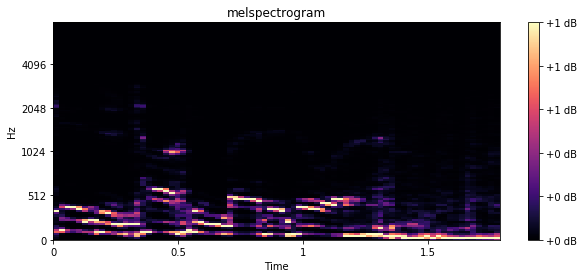

(128, 125)


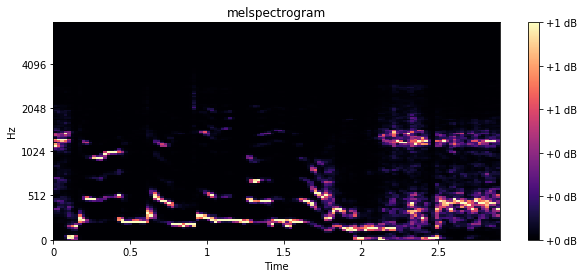

In [40]:
import IPython.display as ipd

audio_file_paths = ['processed_at_lv1/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01-seg0.wav',
                   'processed_at_lv1/Audio_Speech_Actors_01-24/Actor_01/03-01-06-02-02-01-01-seg0.wav']

for audio_file_path in audio_file_paths:
    samples, sample_rate = librosa.load(audio_file_path)
    player = ipd.Audio(audio_file_path)
    ipd.display(player)
    
    samples = butter_bandpass_filter(samples, sample_rate)
    
    spectrogram = get_melspectrogram(samples, sample_rate)
    display_spectrogram(spectrogram)
    


Obtain all audio files, convert them into spectrograms, and extract the emotion labels from the file names. Currently we are only trying to classify anger, therefore all other emotion labels are combined into one. 

In [45]:
N_MINIMUM_SAMPLES = 30000 # samples with lower than 30000 frames ususally do not contain utterances so we drop them

spectrograms = []
labels = []

# takes about 6-8 min on my machine
counter = 0
for audio_file in glob.iglob(str(audio_root_dir / audio_file_pattern), recursive=True):
    samples, sample_rate = librosa.load(audio_file)
    
    if len(samples) > N_MINIMUM_SAMPLES: 
        samples = butter_bandpass_filter(samples, sample_rate)
        spectrogram = get_melspectrogram(samples, sample_rate)

        labels.append(get_emotion_label(audio_file))
        spectrograms.append(duplicate_and_stack(align(spectrogram)))

        if counter % 100 == 0:
            print('Processing the {}th file: {}'.format(counter, audio_file))
        counter += 1

Processing the 0th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_13/03-01-04-01-01-02-13-seg0.wav
Processing the 100th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_04/03-01-03-02-02-01-04-seg0.wav
Processing the 200th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_20/03-01-01-01-02-01-20-seg0.wav
Processing the 300th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_10/03-01-08-02-02-01-10-seg0.wav
Processing the 400th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_01/03-01-07-02-02-01-01-seg0.wav
Processing the 500th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_16/03-01-02-02-02-01-16-seg0.wav
Processing the 600th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_19/03-01-05-01-01-02-19-seg0.wav
Processing the 700th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_07/03-01-07-01-01-01-07-seg0.wav
Processing the 800th file: processed_at_lv1/Audio_Speech_Actors_01-24/Actor_11/03-01-08-01-02-02-11-seg0.wav
Processing the 900th 

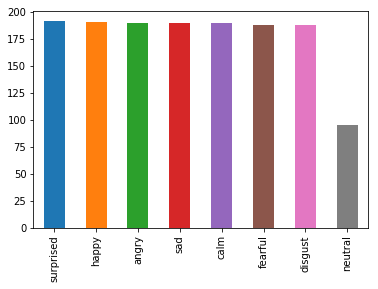

In [46]:
import pandas as pd
labels_dict = dict(zip(range(8), 
                       ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']))
df = pd.DataFrame(labels, columns=['label'])
df.replace({"label": labels_dict}, inplace=True)
df['label'].value_counts().plot(kind='bar')

In [50]:
spectrograms = np.array(spectrograms)
labels = np.array(labels)

In [51]:
spectrograms.shape

(1425, 128, 100, 3)

In [66]:
from sklearn.model_selection import train_test_split
import keras

X_train, X_test, y_train_numerical, y_test_numerical = train_test_split(
    spectrograms, labels, test_size=0.4, random_state=0)

num_classes = 8
y_train = keras.utils.to_categorical(y_train_numerical, num_classes)
y_test = keras.utils.to_categorical(y_test_numerical, num_classes)

split_data = [X_train, X_test, y_train, y_test]
for data in split_data:
    print(data.shape)

(855, 128, 100, 3)
(570, 128, 100, 3)
(855, 8)
(570, 8)


#580 calm: shape - (128, 100)
[0. 1. 0. 0. 0. 0. 0. 0.]
(128, 100)


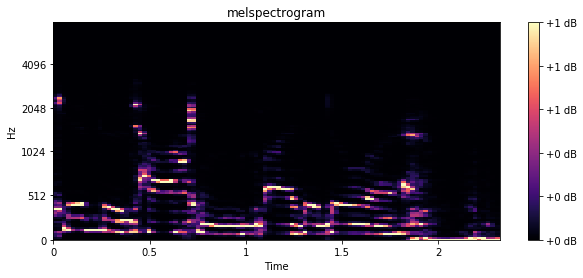

#766 sad: shape - (128, 100)
[0. 0. 0. 1. 0. 0. 0. 0.]
(128, 100)


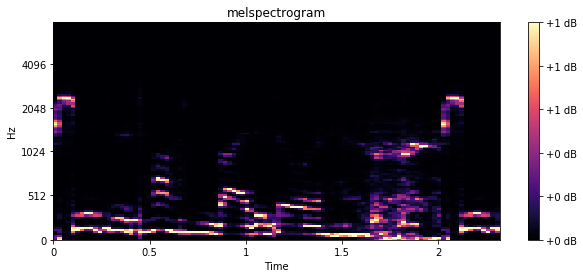

#749 disgust: shape - (128, 100)
[0. 0. 0. 0. 0. 0. 1. 0.]
(128, 100)


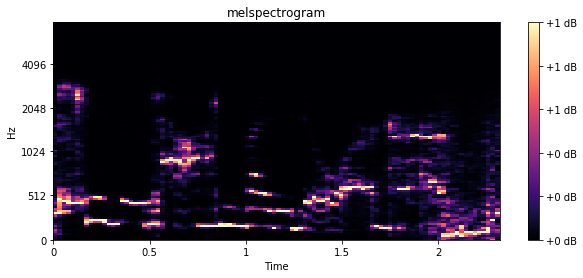

#160 sad: shape - (128, 100)
[0. 0. 0. 1. 0. 0. 0. 0.]
(128, 100)


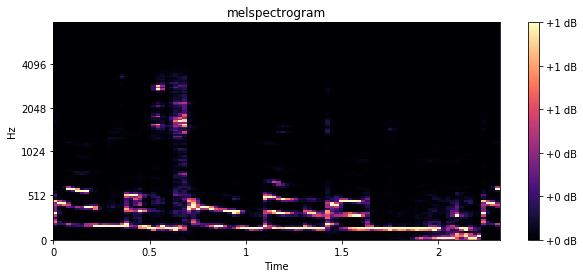

#62 surprised: shape - (128, 100)
[0. 0. 0. 0. 0. 0. 0. 1.]
(128, 100)


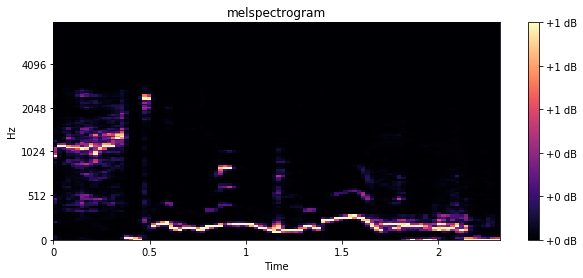

#231 sad: shape - (128, 100)
[0. 0. 0. 1. 0. 0. 0. 0.]
(128, 100)


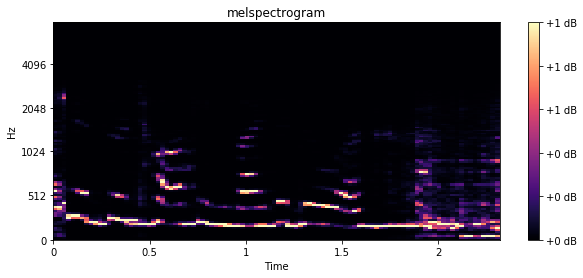

#245 angry: shape - (128, 100)
[0. 0. 0. 0. 1. 0. 0. 0.]
(128, 100)


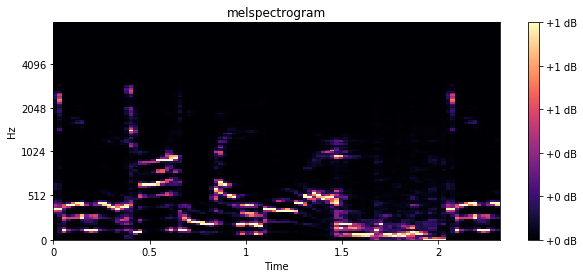

#711 calm: shape - (128, 100)
[0. 1. 0. 0. 0. 0. 0. 0.]
(128, 100)


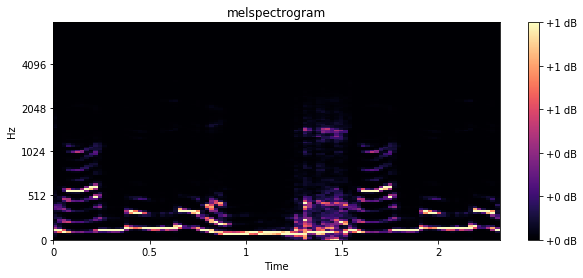

In [84]:
import random
indices = random.sample(range(800), 8)

for index in indices:
    print('#{} {}: shape - {}'.format(index, labels_dict[y_train_numerical[index]], X_train[index][:, :, 0].shape))
    print(y_train[index])
    display_spectrogram(X_train[index][:, :, 0])

In [95]:
from keras import applications

# If you are only interested in convolution filters. Note that by not
# specifying the shape of top layers, the input tensor shape is (None, None, 3),
# so you can use them for any size of images.

# If you want to specify input tensor
from keras.layers import Input

input_tensor = Input(shape=(128, 100, 3))
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)

# To see the models' architecture and layer names, run the following
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 25, 128)       0         
__________

In [96]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block2_pool'].output

# Stacking a new simple convolutional network on top of it    
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:7]:
    layer.trainable = False

# Do not forget to compile it
custom_model.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [97]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 25, 128)       0         
__________

In [98]:
from keras import callbacks

log_dir = str(Path('./Graph'))
tbCallBack = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

In [100]:
custom_model.fit(x=X_test, 
                 y=y_test, 
                 epochs=20, 
                 verbose=1, 
                 callbacks=[tbCallBack],
                 validation_data=(X_test, y_test))

Train on 570 samples, validate on 570 samples
Epoch 1/20
570/570 [==============================] - 13s 23ms/step - loss: 13.8089 - acc: 0.1421 - val_loss: 14.0538 - val_acc: 0.1281
Epoch 2/20
570/570 [==============================] - 13s 23ms/step - loss: 13.7949 - acc: 0.1439 - val_loss: 13.7711 - val_acc: 0.1456
Epoch 3/20
570/570 [==============================] - 13s 22ms/step - loss: 13.7711 - acc: 0.1456 - val_loss: 13.7711 - val_acc: 0.1456
Epoch 4/20
570/570 [==============================] - 13s 22ms/step - loss: 13.8135 - acc: 0.1421 - val_loss: 13.7711 - val_acc: 0.1456
Epoch 5/20
352/570 [=================>............] - ETA: 2s - loss: 13.9982 - acc: 0.1278

KeyboardInterrupt: 

In [92]:
score = custom_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 10.805628010264615
Test accuracy: 0.1035087720605365
